<a href="https://colab.research.google.com/github/leihuang/scrapbook/blob/master/DANN_Moons_GRAAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


https://github.com/GRAAL-Research/domain_adversarial_neural_network/blob/master/DANN.py

In [ ]:
import os
import time
import numpy as np
from math import sqrt
import random
import copy

import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_auc_score
# from DANN import DANN

from matplotlib import pyplot 
plt = pyplot
from scipy.spatial.distance import cdist


SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# DANN class

In [ ]:
class DANN(object):
    def __init__(self, learning_rate=0.05, hidden_layer_size=25, lambda_adapt=1., maxiter=200,  
                 epsilon_init=None, adversarial_representation=True, seed=SEED, verbose=False):
        """
        Domain Adversarial Neural Network for classification
        
        option "learning_rate" is the learning rate of the neural network.
        option "hidden_layer_size" is the hidden layer size.
        option "lambda_adapt" weights the domain adaptation regularization term.
                if 0 or None or False, then no domain adaptation regularization is performed
        option "maxiter" number of training iterations.
        option "epsilon_init" is a term used for initialization.
                if None the weight matrices are weighted by 6/(sqrt(r+c))
                (where r and c are the dimensions of the weight matrix)
        option "adversarial_representation": if False, the adversarial classifier is trained
                but has no impact on the hidden layer representation. The label predictor is
                then the same as a standard neural-network one (see experiments_moon.py figures). 
        option "seed" is the seed of the random number generator.
        """
        self.hidden_layer_size = hidden_layer_size
        self.maxiter = maxiter
        self.lambda_adapt = lambda_adapt if lambda_adapt not in (None, False) else 0.
        self.epsilon_init = epsilon_init
        self.learning_rate = learning_rate
        self.adversarial_representation = adversarial_representation
        self.seed = seed
        self.verbose = verbose
            

    def sigmoid(self, z):
        """
        Sigmoid function.
        """
        return 1. / (1. + np.exp(-z))
    

    def softmax(self, z):
        """
        Softmax function.
        """
        v = np.exp(z)
        return v / np.sum(v, axis=0)
       

    def set_parameter_values(self, **kwargs):
        """
        """
        self.W, self.V, self.b, self.c, self.U, self.d =\
            copy.copy(kwargs['W']),\
            copy.copy(kwargs['V']),\
            copy.copy(kwargs['b']),\
            copy.copy(kwargs['c']),\
            copy.copy(kwargs['U']),\
            copy.copy(kwargs['d']) 


    def fit(self, X, Y, X_adapt, X_valid=None, Y_valid=None, do_random_init=True):
        """         
        Trains the domain adversarial neural network until it reaches a total number of
        iterations of "self.maxiter" since it was initialize.
        inputs:
              X : Source data matrix
              Y : Source labels
              X_adapt : Target data matrix
              (X_valid, Y_valid) : validation set used for early stopping.
              do_random_init : A boolean indicating whether to use random initialization or not.
        """
        nb_examples, nb_features = np.shape(X)
        nb_labels = len(set(Y))
        nb_examples_adapt, _ = np.shape(X_adapt)

        W, V, b, c, U, d = self.W, self.V, self.b, self.c, self.U, self.d 

        for t in range(self.maxiter):
            for i in range(nb_examples):
                x_t, y_t = X[i,:], Y[i]
                
                hidden_layer = self.sigmoid(np.dot(W, x_t) + b)
                output_layer = self.softmax(np.dot(V, hidden_layer) + c)
                
                y_hot = np.zeros(nb_labels)
                y_hot[y_t] = 1.0
                
                delta_c = output_layer - y_hot  
                delta_V = np.dot(delta_c.reshape(-1,1), hidden_layer.reshape(1,-1)) 
                delta_b = np.dot(V.T, delta_c) * hidden_layer * (1.-hidden_layer) 
                delta_W = np.dot(delta_b.reshape(-1,1), x_t.reshape(1,-1)) 
                
                if self.lambda_adapt == 0.:
                    delta_U, delta_d = 0., 0.
                else:
                    # add domain adaptation regularizer from current domain
                    gho_x_t = self.sigmoid(np.dot(U.T, hidden_layer) + d)
                    
                    delta_d = self.lambda_adapt * (1. - gho_x_t) 
                    delta_U = delta_d * hidden_layer 

                    if self.adversarial_representation:
                        tmp = delta_d * U * hidden_layer * (1. - hidden_layer)
                        delta_b += tmp
                        delta_W += tmp.reshape(-1,1) * x_t.reshape(1,-1)
                    
                    # add domain adaptation regularizer from other domain
                    x_t_2 = X_adapt[i, :]
                    hidden_layer_2 = self.sigmoid( np.dot(W, x_t_2) + b)
                    gho_x_t_2 = self.sigmoid(np.dot(U.T, hidden_layer_2) + d) 
                    
                    delta_d -= self.lambda_adapt * gho_x_t_2 
                    delta_U -= self.lambda_adapt * gho_x_t_2 * hidden_layer_2

                    if self.adversarial_representation:
                        tmp = -self.lambda_adapt * gho_x_t_2 * U * hidden_layer_2 * (1. - hidden_layer_2)
                        delta_b += tmp
                        delta_W += tmp.reshape(-1,1) * x_t_2.reshape(1,-1)
          
                W -= delta_W * self.learning_rate
                b -= delta_b * self.learning_rate
     
                V -= delta_V * self.learning_rate
                c -= delta_c * self.learning_rate
                
                U += delta_U * self.learning_rate 
                d += delta_d * self.learning_rate 
            # END for i in range(nb_examples)

            self.W, self.V, self.b, self.c, self.U, self.d = W, V, b, c, U, d
        # END for t in range(self.maxiter)
            

    def forward(self, X):
        """
         Compute and return the network outputs for X, i.e., a 2D array of size len(X) by len(set(Y)).
         the ith row of the array contains output probabilities for each class for the ith example.
         
        """
        hidden_layer = self.sigmoid(np.dot(self.W, X.T) + self.b[:,np.newaxis])
        output_layer = self.softmax(np.dot(self.V, hidden_layer) + self.c[:,np.newaxis])
        return output_layer


    def hidden_representation(self, X):
        """
         Compute and return the network hidden layer values for X.
        """
        hidden_layer = self.sigmoid(np.dot(self.W, X.T) + self.b[:,np.newaxis])
        return hidden_layer.T


    def predict(self, X):
        """
         Compute and return the label predictions for X, i.e., a 1D array of size len(X).
         the ith row of the array contains the predicted class for the ith example .
        """
        output_layer = self.forward(X)
        return np.argmax(output_layer, 0)


    def predict_domain(self, X):
        """
         Compute and return the domain predictions for X, i.e., a 1D array of size len(X).
         the ith row of the array contains the predicted domain (0 or 1) for the ith example.
        """
        hidden_layer = self.sigmoid(np.dot(self.W, X.T) + self.b[:, np.newaxis])
        output_layer = self.sigmoid(np.dot(self.U, hidden_layer) + self.d)
        return np.array(output_layer < .5, dtype=int)

# main()

In [ ]:
def main():
    X, y, Xt, yt = make_trans_moons(35, nb=150)
    Xall = np.vstack((X, Xt))

    special = np.array([[-2.4, -1.6], [-1.2, 0.4], [.8, -.5], [2.5, 1.5]])
    special_points = Xall[np.argmin(cdist(special, Xall), axis=1), :]

    # Standard NN
    algo = DANN(hidden_layer_size=15, maxiter=500, lambda_adapt=6., seed=42, adversarial_representation=False)
    algo.fit(X, y, Xt)


    pyplot.figure(figsize=(20,10))
    pyplot.subplot(2, 4, 1)
    pyplot.title("NN: Label classification")
    draw_trans_data(X, y, Xt, algo.predict, special_points=special_points,
                    special_xytext=[(40, -15), (-30, -80), (-50, 40), (-70, 0)])

    pyplot.subplot(2, 4, 2)
    pyplot.title("NN: Representation PCA")
    run_pca(X, y, Xt, algo, special_points=special_points, mult=[-1, -1])

    pyplot.subplot(2, 4, 3)
    pyplot.title("NN: Domain classification")
    draw_trans_data(X, y, Xt, algo.predict_domain, colormap_index=1)

    pyplot.subplot(2, 4, 4)
    pyplot.title("NN: Hidden neurons")
    draw_trans_data(X, y, Xt, neurons_to_draw=(algo.W, algo.b))

    # DANN
    algo = DANN(hidden_layer_size=15, maxiter=500, lambda_adapt=6., seed=42)
    algo.fit(X, y, Xt)

    pyplot.subplot(2, 4, 5)
    pyplot.title("DANN: Label classification")
    draw_trans_data(X, y, Xt, algo.predict,  special_points=special_points,
                    special_xytext=[(50,-15), (-20,-90), (-50,40), (-80,0)] )

    pyplot.subplot(2, 4, 6)
    pyplot.title("DANN: Representation PCA")
    run_pca(X, y, Xt, algo, special_points=special_points, mult=[-1,1],
            special_xytext=[(-10,-80), (50,-60), (-40,50), (-20,70)])

    pyplot.subplot(2, 4, 7)
    pyplot.title("DANN: Domain classification")
    draw_trans_data(X, y, Xt, algo.predict_domain, colormap_index=1)

    pyplot.subplot(2, 4, 8)
    pyplot.title("DANN: Hidden neurons")
    draw_trans_data(X, y, Xt, neurons_to_draw=(algo.W, algo.b))

    pyplot.show()


def make_trans_moons(theta=40, nb=100, noise=.05):
    from math import cos, sin, pi
    
    X, y = make_moons(nb, noise=noise, random_state=1) 
    Xt, yt = make_moons(nb, noise=noise, random_state=2)
    
    trans = -np.mean(X, axis=0) 
    X  = 2*(X+trans)
    Xt = 2*(Xt+trans)
    
    theta = -theta*pi/180
    rotation = np.array( [  [cos(theta), sin(theta)], [-sin(theta), cos(theta)] ] )
    Xt = np.dot(Xt, rotation.T)
    
    return X, y, Xt, yt


def draw_trans_data(X, y, Xt, predict_fct=None, neurons_to_draw=None, colormap_index=0, special_points=None, special_xytext=None):
    # Some line of codes come from: http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

    if colormap_index==0:
        cm_bright = ListedColormap(['#FF0000', '#00FF00'])
    else:
        cm_bright = ListedColormap(['#0000FF', '#000000'])

    x_min, x_max = 1.1*X[:, 0].min(), 1.1*X[:, 0].max()
    y_min, y_max = 1.5*X[:, 1].min(), 1.5*X[:, 1].max()
        
    pyplot.xlim((x_min,x_max))
    pyplot.ylim((y_min,y_max))
    
    pyplot.tick_params(direction='in', labelleft=False)    

    if predict_fct is not None:
        h = .02  # step size in the mesh

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        Z = predict_fct(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        pyplot.contourf(xx, yy, Z, cmap=cm_bright, alpha=.4)
        pyplot.contour(xx, yy, Z, colors='black', linewidths=5)

    if X is not None:
        for i in range(len(y)):
            if y[i] == 1:
                pyplot.annotate("-", X[i,:], color="green", size=50*1.5, textcoords='offset points', xytext=(-6*1.5,-13*1.5))
            else:
                pyplot.annotate("+", X[i,:], color="red", size=30*1.5, textcoords='offset points', xytext=(-8*1.5,-8*1.5))

    if Xt is not None:
        pyplot.scatter(Xt[:, 0], Xt[:, 1], c='k', s=40)

    if special_points is not None:
        for i in range(np.shape(special_points)[0]):
            if special_xytext is None:
                xytext = (30,45) if i%2 == 1 else (-40,-60)
            else:
                xytext = special_xytext[i]
                
            pyplot.annotate('ABCDEFG'[i], special_points[i,:], xycoords='data', color="blue",
                xytext=xytext, textcoords='offset points',
                size=32,
                arrowprops=dict(arrowstyle="fancy", fc=(0., 0., 1.), ec="none", connectionstyle="arc3,rad=0.0"))
        
    if neurons_to_draw is not None:
        for w12, b in zip(neurons_to_draw[0], neurons_to_draw[1]):
            w1, w2 = w12
            get_y = lambda x: -(w1*x+b)/w2
            pyplot.plot([x_min,x_max], [get_y(x_min), get_y(x_max)])


def run_pca(X, y, Xt, algo, special_points=None, special_xytext=None, mult=None):
    if mult is None: # mult is used to flip the representation
        mult = np.ones(2)

    h_X = algo.hidden_representation(X)
    h_Xt = algo.hidden_representation(Xt)

    pca = PCA(n_components=2)
    pca.fit(np.vstack((h_X, h_Xt)))

    if special_points is not None:
        special_points = mult*pca.transform(algo.hidden_representation(special_points))

    draw_trans_data(mult*pca.transform(h_X), y, mult*pca.transform(h_Xt), special_points=special_points,
                    special_xytext=special_xytext)

In [ ]:
# main()

In [ ]:
X, y, Xt, yt = make_trans_moons(35, nb=150)
Xall = np.vstack((X, Xt))

# Standard NN
algo0 = DANN(hidden_layer_size=15, maxiter=500, lambda_adapt=6., seed=42, adversarial_representation=False)
# algo0.fit(X, y, Xt)

# DANN
algo = DANN(hidden_layer_size=15, maxiter=500, lambda_adapt=6., seed=42)
# algo.fit(X, y, Xt, do_random_init=False)

# Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, Function
from torch.utils.data import Dataset, DataLoader
import tqdm


class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None


class AdversarialLoss(nn.Module):
    def __init__(self):
        super(AdversarialLoss, self).__init__()
        self.Gd = nn.Sequential(nn.Linear(15, 1), nn.Sigmoid())
        
    def forward(self, Xs, Xt):
        loss_adv_source = self.get_adversarial_result(Xs, domain='source')
        loss_adv_target = self.get_adversarial_result(Xt, domain='target')
        loss_adv = 1 * (loss_adv_source + loss_adv_target)
        return loss_adv
    
    def get_adversarial_result(self, X, domain):
        X = ReverseLayerF.apply(X, 1)
        dh = self.Gd(X)
        if domain == 'source':
            d = torch.ones(len(X), 1).long()
        elif domain == 'target':
            d = torch.zeros(len(X), 1).long()
        else:
            raise ValueError
        loss_fn = nn.BCELoss()
        loss_adv = loss_fn(dh, d.float())
        return loss_adv


class DANN2(nn.Module):
    def __init__(self):
        super(DANN2, self).__init__()
        self.Gf = nn.Sequential(nn.Linear(2, 15), nn.Sigmoid())
        self.Gy = nn.Sequential(nn.Linear(15, 1), nn.Sigmoid())
        self.adv = AdversarialLoss()

    def forward(self, Xs, Xt):
        Xs_ = self.Gf(Xs)
        Xt_ = self.Gf(Xt)
        yhs = self.Gy(Xs_)[:,0]
        loss_adv = self.adv(Xs_, Xt_) 
        return yhs, loss_adv

    def predict(self, X):
        X_ = self.Gf(X)
        yh = self.Gy(X_)
        return yh


    def get_optimizer(self, **kwargs):
        """
        """
        lr = kwargs['lr']
        momentum = kwargs['momentum']

        params = [{'params': self.Gf.parameters(), 'lr': lr},  
                  {'params': self.Gy.parameters(), 'lr': lr},
                  {'params': self.adv.domain_classifier.parameters(), 'lr': lr}]
            
        optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum)  
        return optimizer


class CustomDataset(Dataset):
    """
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X_ = self.X[index]
        y_ = self.y[index]
        return X_, y_


def get_W(net):
    return dict(net.Gf.named_parameters())['0.weight'].data.detach().numpy()

def get_b(net):
    return dict(net.Gf.named_parameters())['0.bias'].data.detach().numpy()

def get_V(net):
    return dict(net.Gy.named_parameters())['0.weight'].data.detach().numpy()

def get_c(net):
    return dict(net.Gy.named_parameters())['0.bias'].data.detach().numpy()

def get_U(net):
    return dict(net.Gd.named_parameters())['0.weight'].data.detach().numpy()

def get_d(net):
    return dict(net.Gd.named_parameters())['0.bias'].data.detach().numpy()[0]

In [ ]:
class DANN3(nn.Module):
    def __init__(self, width, domain_adversarial=False):
        super(DANN3, self).__init__()
        self.Gf = nn.Sequential(nn.Linear(2, width), nn.Sigmoid())
        self.Gy = nn.Sequential(nn.Linear(width, 2))
        self.domain_adversarial = domain_adversarial 
        if domain_adversarial:
            self.Gd = nn.Sequential(nn.Linear(width, 1), nn.Sigmoid())

    def forward(self, X):
        X_ = self.Gf(X)
        yhat = self.Gy(X_)
        if self.domain_adversarial:
            dhat = self.Gd(ReverseLayerF.apply(X_, 1))[:,0]
            return yhat, dhat
        else:
            return yhat

    def predict_proba(self, X):
        X_ = self.Gf(X)
        yhat = self.Gy(X_)
        p = torch.nn.Softmax()(yhat)[:,1]
        return p

    def predict_label(self, X):
        X_ = self.Gf(X)
        yhat = self.Gy(X_)
        p = torch.nn.Softmax(dim=1)(yhat)
        return p.max(dim=1)[1]
        

    # def get_optimizer(self, lr):
    #     """
    #     """
    #     params = [{'params': self.Gf.parameters(), 'lr': lr},  
    #               {'params': self.Gy.parameters(), 'lr': lr},
    #               #{'params': self.Gd.parameters(), 'lr': lr}
    #               ]
    #     optimizer = torch.optim.SGD(params, lr=lr)
    #     return optimizer

# Match

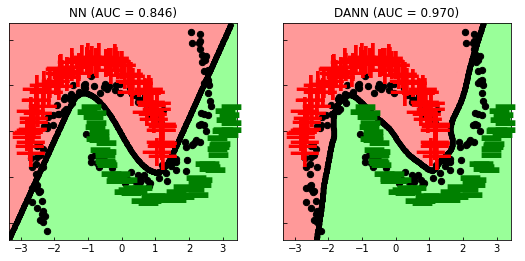

In [ ]:
set_seed(SEED)
net3_ = DANN3(15, domain_adversarial=True).double()

params = {}
for name, param in net3_.named_parameters():
    params[name] = param.data.numpy()
params = pd.Series(params)

params.rename({'Gf.0.weight': 'W', 
               'Gf.0.bias': 'b',
               'Gy.0.weight': 'V',
               'Gy.0.bias': 'c',
               'Gd.0.weight': 'U',
               'Gd.0.bias': 'd'}, inplace=True)
params = params.to_dict()
params['U'] = params['U'].flatten()
params['d'] = params['d'][0]

maxiter = 500

net0 = DANN(hidden_layer_size=15, learning_rate=0.05, lambda_adapt=6., seed=SEED, maxiter=maxiter, adversarial_representation=False)
net0.set_parameter_values(**params)
net0.fit(X, y, Xt, do_random_init=False)

pyplot.figure(figsize=(9,4))
pyplot.subplot(1, 2, 1)
pyplot.title("NN (AUC = %.3f)" % roc_auc_score(yt, net0.forward(Xt)[1]))
draw_trans_data(X, y, Xt, net0.predict)

net = DANN(hidden_layer_size=15, learning_rate=0.05, lambda_adapt=6., seed=SEED, maxiter=maxiter, adversarial_representation=True)
net.set_parameter_values(**params)
net.fit(X, y, Xt, do_random_init=False)

pyplot.subplot(1, 2, 2)
pyplot.title("DANN (AUC = %.3f)" % roc_auc_score(yt, net.forward(Xt)[1]))
draw_trans_data(X, y, Xt, net.predict)
pyplot.show()

In [ ]:
X, y, Xt, yt = make_trans_moons(35, nb=150)

_X = Variable(torch.from_numpy(X)).double()
_y = Variable(torch.from_numpy(y)).long()
_Xt = Variable(torch.from_numpy(Xt)).double()
_yt = Variable(torch.from_numpy(yt)).long()

dataset_src = CustomDataset(_X, _y)
dataloader_src = DataLoader(dataset_src, batch_size=1, shuffle=False) 

dataset_tar = CustomDataset(_Xt, _yt)
dataloader_tar = DataLoader(dataset_tar, batch_size=1, shuffle=False) 

len(dataloader_tar)

150

In [ ]:
set_seed(SEED)
net3_ = DANN3(15, domain_adversarial=True).double()

params = {}
for name, param in net3_.named_parameters():
    params[name] = copy.copy(param.data.numpy())
params = pd.Series(params)

params.rename({'Gf.0.weight': 'W', 
               'Gf.0.bias': 'b',
               'Gy.0.weight': 'V',
               'Gy.0.bias': 'c',
               'Gd.0.weight': 'U',
               'Gd.0.bias': 'd'}, inplace=True)
params = params.to_dict()
params['U'] = params['U'].flatten()
params['d'] = params['d'][0]

net = DANN(hidden_layer_size=5, learning_rate=0.05, lambda_adapt=6., seed=SEED, 
           maxiter=500, adversarial_representation=True, verbose=False)
net.set_parameter_values(**params)

net.fit(X, y, Xt, do_random_init=False)

In [ ]:
set_seed(SEED)
net3_ = DANN3(15, domain_adversarial=True).double()

params = {}
for name, param in net3_.named_parameters():
    params[name] = copy.copy(param.data.numpy())
params = pd.Series(params)

params.rename({'Gf.0.weight': 'W', 
               'Gf.0.bias': 'b',
               'Gy.0.weight': 'V',
               'Gy.0.bias': 'c',
               'Gd.0.weight': 'U',
               'Gd.0.bias': 'd'}, inplace=True)
params = params.to_dict()
params['U'] = params['U'].flatten()
params['d'] = params['d'][0]

net0 = DANN(hidden_layer_size=5, learning_rate=0.05, lambda_adapt=6., seed=SEED, 
            maxiter=500, adversarial_representation=False, verbose=False)
net0.set_parameter_values(**params)

net0.fit(X, y, Xt, do_random_init=False)

In [ ]:
# set_seed(SEED)
# net3_ = DANN3(15, domain_adversarial=True).double()

# params = {}
# for name, param in net3_.named_parameters():
#     params[name] = copy.copy(param.data.numpy())
# params = pd.Series(params)

# params.rename({'Gf.0.weight': 'W', 
#                'Gf.0.bias': 'b',
#                'Gy.0.weight': 'V',
#                'Gy.0.bias': 'c',
#                'Gd.0.weight': 'U',
#                'Gd.0.bias': 'd'}, inplace=True)
# params = params.to_dict()
# params['U'] = params['U'].flatten()
# params['d'] = params['d'][0]

# net = DANN(hidden_layer_size=15, learning_rate=0.05, lambda_adapt=6, seed=SEED, 
#            maxiter=10, adversarial_representation=True, verbose=False)
# net.set_parameter_values(**params)


# nb_examples, nb_features = np.shape(X)
# nb_labels = len(set(y))

# W, V, b, c, U, d = net.W, net.V, net.b, net.c, net.U, net.d

# for t in range(10):
#     for i in range(nb_examples):
#         x_t, y_t = X[i,:], y[i]
        
#         hidden_layer = net.sigmoid(np.dot(W, x_t) + b)
#         output_layer = net.softmax(np.dot(V, hidden_layer) + c)
        
#         y_hot = np.zeros(nb_labels)
#         y_hot[y_t] = 1.0
        
#         delta_c = output_layer - y_hot  
#         delta_V = np.dot(delta_c.reshape(-1,1), hidden_layer.reshape(1,-1)) 
#         delta_b = np.dot(V.T, delta_c) * hidden_layer * (1.-hidden_layer) 
#         delta_W = np.dot(delta_b.reshape(-1,1), x_t.reshape(1,-1)) 

#         # add domain adaptation regularizer from current domain
#         gho_x_t = net.sigmoid(np.dot(U.T, hidden_layer) + d)
        
#         delta_d = net.lambda_adapt * (1. - gho_x_t) 
#         delta_U = delta_d * hidden_layer 

#         if net.adversarial_representation:
#             tmp = delta_d * U * hidden_layer * (1. - hidden_layer)
#             delta_b += tmp
#             delta_W += tmp.reshape(-1,1) * x_t.reshape(1,-1)
        
#         # add domain adaptation regularizer from other domain
#         x_t_2 = Xt[i, :]
#         hidden_layer_2 = net.sigmoid( np.dot(W, x_t_2) + b)
#         gho_x_t_2 = net.sigmoid(np.dot(U.T, hidden_layer_2) + d) 
        
#         delta_d -= net.lambda_adapt * gho_x_t_2 
#         delta_U -= net.lambda_adapt * gho_x_t_2 * hidden_layer_2

#         if net.adversarial_representation:
#             tmp = -net.lambda_adapt * gho_x_t_2 * U * hidden_layer_2 * (1. - hidden_layer_2)
#             delta_b += tmp
#             delta_W += tmp.reshape(-1,1) * x_t_2.reshape(1,-1)
    
#         W -= delta_W * net.learning_rate
#         b -= delta_b * net.learning_rate

#         V -= delta_V * net.learning_rate
#         c -= delta_c * net.learning_rate
        
#         U += delta_U * net.learning_rate 
#         d += delta_d * net.learning_rate 

In [ ]:
set_seed(SEED)
net3 = DANN3(15, domain_adversarial=True).double()

optimizer = torch.optim.SGD(net3.parameters(), lr=0.05)
lossfn_y = nn.CrossEntropyLoss()
lossfn_d = nn.BCELoss()

for epoch in range(500):
    net3.train()
    for (X_batch_src, y_batch_src), (X_batch_tar, y_batch_tar) in zip(dataloader_src, dataloader_tar):
        yhat_src, dhat_src = net3(X_batch_src)
        yhat_tar, dhat_tar = net3(X_batch_tar)

        loss_y = lossfn_y(yhat_src, y_batch_src)
        loss_d_src = lossfn_d(dhat_src, torch.tensor([1.]).double())
        loss_d_tar = lossfn_d(dhat_tar, torch.tensor([0.]).double())
        loss = loss_y + 6. * (loss_d_src + loss_d_tar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
set_seed(SEED)
net2 = DANN3(15, domain_adversarial=False).double()

optimizer = torch.optim.SGD(net2.parameters(), lr=0.05)
lossfn_y = nn.CrossEntropyLoss()

for epoch in range(500):
    net2.train()
    for (X_batch_src, y_batch_src) in dataloader_src:
        yhat_src = net2(X_batch_src)
        loss_y = lossfn_y(yhat_src, y_batch_src)
        loss = loss_y 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


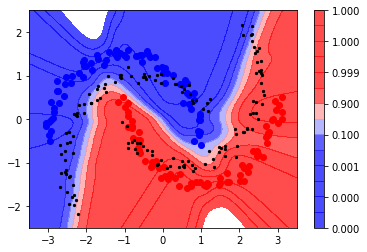

In [ ]:
k = 100
x1s = np.linspace(-3.5, 3.5, k)
x2s = np.linspace(-2.5, 2.5, k)

x1ss, x2ss = np.meshgrid(x1s, x2s)
Xp = np.array(list(zip(x1ss.flatten(), x2ss.flatten())))
Xp_ = Variable(torch.from_numpy(Xp)).double()
zss = net3.predict_proba(Xp_).detach().numpy().reshape(k, k)

fig, ax = plt.subplots()
decades = np.array([1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
levels = list(decades) + [0.5] + list(1-decades[::-1])
contours = plt.contourf(x1ss, x2ss, zss, levels, cmap='bwr', alpha=0.7)
plt.colorbar()

ax.scatter(*X[y==0].T, color='b')
ax.scatter(*X[y==1].T, color='r')
ax.scatter(*Xt.T, color='k', s=5)

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


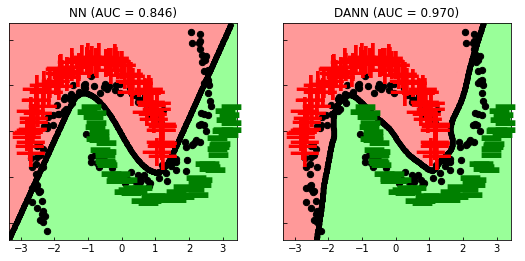

In [ ]:
def get_predict_func_label(net):
    def predict_func(X):
        X_ = Variable(torch.from_numpy(X)).double()
        p = net.predict_label(X_)
        return p.detach().numpy()
    return predict_func

def get_predict_func_proba(net):
    def predict_func(X):
        X_ = Variable(torch.from_numpy(X)).double()
        p = net.predict_proba(X_)
        return p.detach().numpy()
    return predict_func

pyplot.figure(figsize=(9,4))
pyplot.subplot(1, 2, 1)
pyplot.title("NN (AUC = %.3f)" % roc_auc_score(yt, get_predict_func_proba(net2)(Xt)))
draw_trans_data(X, y, Xt, get_predict_func_label(net2))

pyplot.subplot(1, 2, 2)
pyplot.title("DANN (AUC = %.3f)" % roc_auc_score(yt, get_predict_func_proba(net3)(Xt)))
draw_trans_data(X, y, Xt, get_predict_func_label(net3))
pyplot.show()

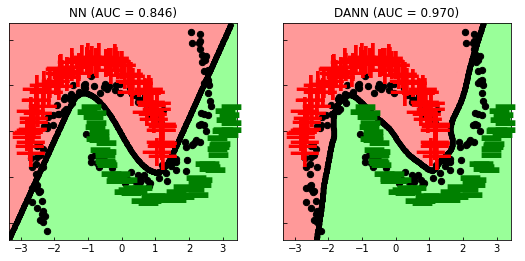

In [ ]:
pyplot.figure(figsize=(9,4))
pyplot.subplot(1, 2, 1)
pyplot.title("NN (AUC = %.3f)" % roc_auc_score(yt, net0.forward(Xt)[1]))
draw_trans_data(X, y, Xt, net0.predict)

pyplot.subplot(1, 2, 2)
pyplot.title("DANN (AUC = %.3f)" % roc_auc_score(yt, net.forward(Xt)[1]))
draw_trans_data(X, y, Xt, net.predict)
pyplot.show()